In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy as sc
from scipy import ndimage
from skimage import filters
from matplotlib import pyplot as plt
from PIL import Image

import plotly.express as px

# sns.set(context='poster')
%matplotlib inline

<IPython.core.display.Javascript object>

### Problem 1

(600, 800, 3)



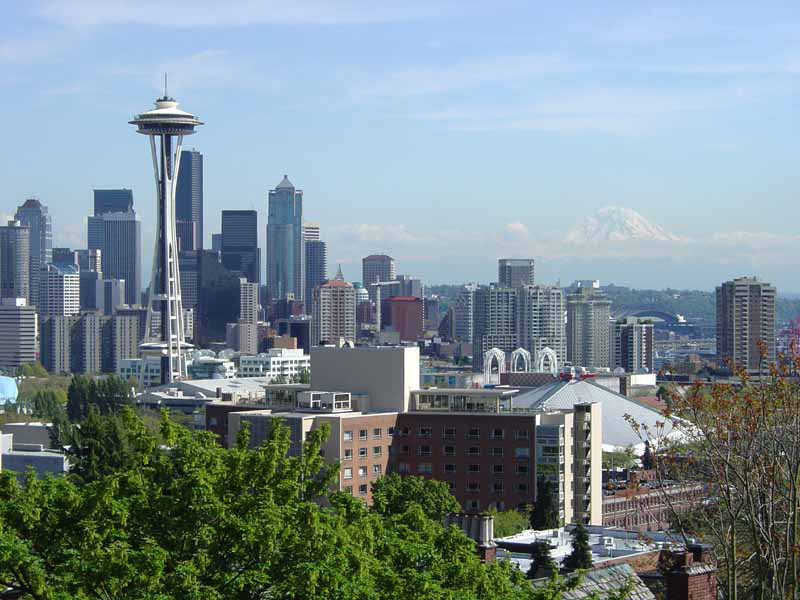

<IPython.core.display.Javascript object>

In [30]:
image = Image.open("hw1_data/Seattle.jpg")  # .convert("L")
image = np.asarray(image)
print(image.shape)
px.imshow(image, color_continuous_scale="gray")

Gaussian filter is defined as: $$ G(\mathbf{x}; \sigma^2) = \frac{1}{2 \pi \sigma^2} \exp{-\frac{\mathbf{x}^T \mathbf{x}}{2 \sigma^2}}$$

In [4]:
# Trick for colors
# np.stack([np.arange(16).reshape(4,4)])*3, axis = -1).shape

# First lets write a convolve function
def convolve(image, flter):
    filter_size = flter.shape[0]

    padimage = imagepadding(image, filter_size)
    # print(padimage.shape)
    rowsize = image.shape[0]
    colsize = image.shape[1]

    im_filtered = np.zeros_like(image, dtype=np.float32)

    for i in range(rowsize):  # rows
        # print("i is ", i)
        for j in range(colsize):  # columns
            # print("j is ", j)
            submat = padimage[i : i + filter_size, j : j + filter_size]
            im_filtered[i, j] = np.sum(np.multiply(submat, flter))
    return im_filtered


# Now lets write a padding function
def imagepadding(image, sizeofpad):
    rowsize = image.shape[0]
    colsize = image.shape[1]

    # Multiply by two since padding is double sided
    padimage = np.zeros(shape=(rowsize + 2 * sizeofpad, colsize + 2 * sizeofpad))

    # Plant the image in the middle of the new matrix, equidistant from the edges
    padimage[sizeofpad:-sizeofpad, sizeofpad:-sizeofpad] = image
    # padimage[1:-sizeofpad, 1:-sizeofpad] = image

    return padimage

<IPython.core.display.Javascript object>


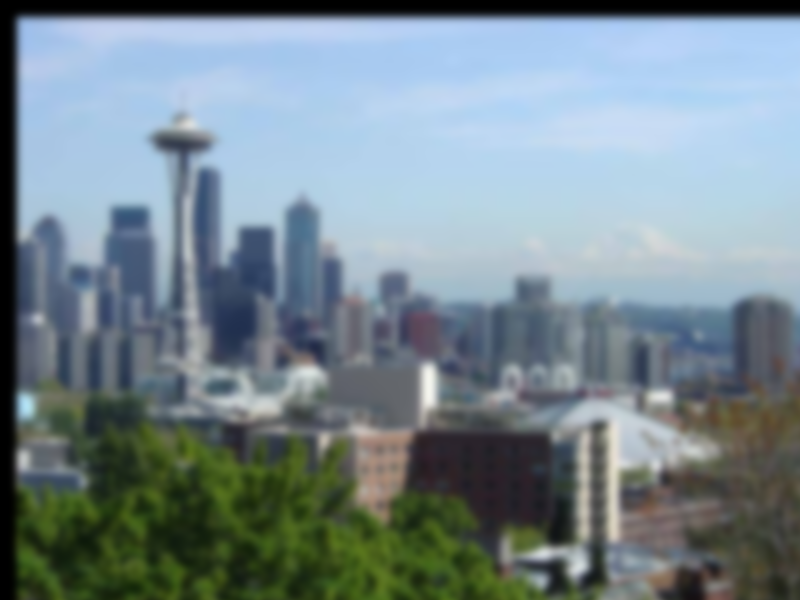

<IPython.core.display.Javascript object>

In [5]:
def GaussianBlurImage(image, sigma):
    # Builds the filter
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
    for i in range(filter_size):
        for j in range(filter_size):
            x = i - filter_size // 2
            y = j - filter_size // 2
            gaussian_filter[i, j] = (
                1
                / (2 * np.pi * sigma ** 2)
                * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
            )

    # Declare blank filter (zeros)
    im_filtered = np.zeros_like(image, dtype=np.float32)

    # Filter for each RGB
    for c in range(3):
        im_filtered[:, :, c] = convolve(image[:, :, c], gaussian_filter)

    fig = px.imshow(np.clip(im_filtered, 0, 255).astype(np.uint8))
    # fig = px.imshow(im_filtered, color_continuous_scale="gray")
    fig.write_image("1.png")
    return fig


GaussianBlurImage(image, 4)

(600, 800, 3)



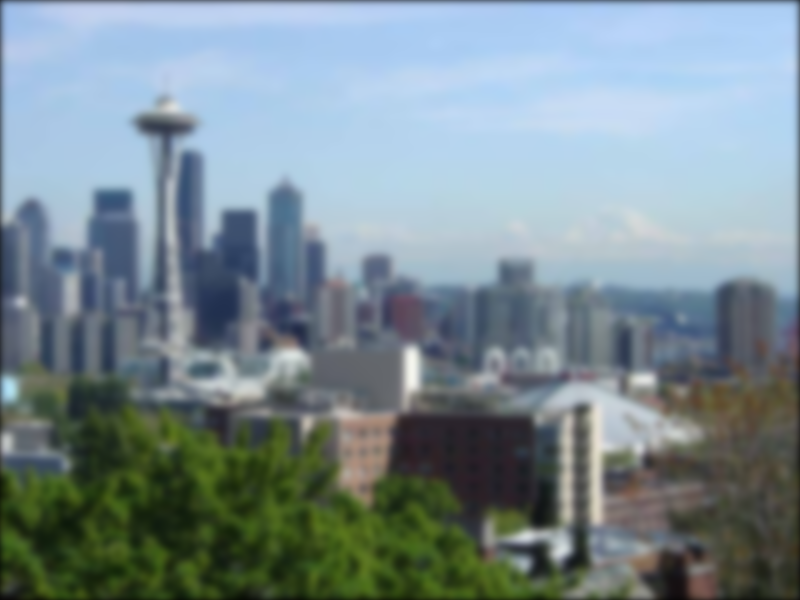

<IPython.core.display.Javascript object>

In [7]:
im_filtered_skimage = filters.gaussian(
    image, sigma=4, mode="constant", cval=0.0, multichannel=True, preserve_range=True
)
print(im_filtered_skimage.shape)
px.imshow(im_filtered_skimage)

### Problem 2

[3.3457556e-05 8.8148918e-05 2.1817068e-04 5.0726201e-04 1.1079621e-03
 2.2733905e-03 4.3820753e-03 7.9349130e-03 1.3497742e-02 2.1569330e-02
 3.2379400e-02 4.5662273e-02 6.0492679e-02 7.5284354e-02 8.8016331e-02
 9.6667029e-02 9.9735573e-02 9.6667029e-02 8.8016331e-02 7.5284354e-02
 6.0492679e-02 4.5662273e-02 3.2379400e-02 2.1569330e-02 1.3497742e-02
 7.9349130e-03 4.3820753e-03 2.2733905e-03 1.1079621e-03 5.0726201e-04
 2.1817068e-04 8.8148918e-05 3.3457556e-05]



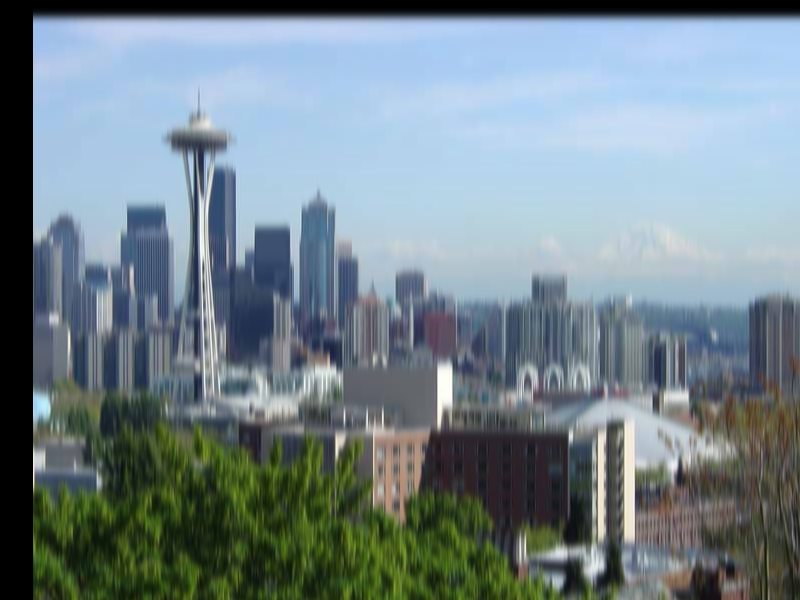

<IPython.core.display.Javascript object>

In [36]:
### ARTIFACTS MIGHT BE BECAUSE OF LACK OF CONVERION TO UINT8 CHECK DISCUSSION NOTEBOOK


def sepConvolve(image, flter, axis=0, padimage=None):
    filter_size = flter.shape[0]
    if padimage is None:
        padimage = imagepadding(image, filter_size)
    else:
        padimage = padimage

    # padimage = imagepadding(image, filter_size)

    # Zeros
    im_filtered = np.zeros_like(image, dtype=np.float32)

    rowsize = image.shape[0]
    colsize = image.shape[1]

    # Conditional for which axis to apply filter on
    if axis == 1:  # column blur
        for i in range(colsize):
            for j in range(rowsize):
                subvec = padimage[j : j + filter_size, i]
                im_filtered[j, i] = np.sum(np.multiply(subvec, flter))
    else:  # row blur
        for i in range(rowsize):
            for j in range(colsize):
                subvec = padimage[i, j : j + filter_size]
                im_filtered[i, j] = np.sum(np.multiply(subvec, flter))
    return im_filtered


def SeparableGaussianBlurImage(image, sigma):
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    # print("Filter size = ", filter_size)
    gaussian_filter = np.zeros((filter_size), np.float32)
    for i in range(filter_size):
        x = i - filter_size // 2

        gaussian_filter[i] = (  # univariate gaussian
            1
            / np.sqrt(2 * np.pi * sigma ** 2)
            * np.exp(
                -(x ** 2) / (2 * sigma ** 2)
            )  # need sqrt in denominator of constant
        )
    print(gaussian_filter)

    im_filtered = np.zeros_like(image, dtype=np.float32)

    #     im_filtered = sepConvolve(image, gaussian_filter, axis=0)
    #     im_filtered = sepConvolve(im_filtered, gaussian_filter, axis=1, padimage=padimage)

    # Filter for each RGB
    for c in range(3):
        # Image padding
        padimage = imagepadding(image[:, :, c], filter_size)
        # Row
        im_filtered[:, :, c] = sepConvolve(image[:, :, c], gaussian_filter, axis=0)
        # Column
        im_filtered[:, :, c] = sepConvolve(
            im_filtered[:, :, c], gaussian_filter, axis=1, padimage=padimage
        )

    fig = px.imshow(np.clip(im_filtered, 0, 255).astype(np.uint8))
    fig.write_image("2.png")

    return fig


SeparableGaussianBlurImage(image, 4.0)

### Problem 3

In [ ]:
yosemite = Image.open("hw1_data/Yosemite.png")
yosemite = np.asarray(yosemite)
px.imshow(yosemite)

In [38]:
def SharpenImage(image, sigma, alpha):
    mask = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    padimage = imagepadding(image, 1)
    
    rowsize = image.shape[0]
    colsize = image.shape[1]
    
    for i in range(rowsize)-2:
        for j in range(colsize)-2:
            


[[ 0  1  0]
 [ 1 -4  1]
 [ 0  1  0]]


<IPython.core.display.Javascript object>